# Imputation Try-outs

In this notebook, we tried out different types of data imputation and their impact on prediction. To keep the comparison fair, we used the same XGBoost regressor.  

In [1]:
# Before Starting up anything, we need to add the folder containing all the source code to Jupyter Notebooks
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\project_code")

In [2]:
# Once added, we can call all our project functions without any issues
from pathlib import Path
import pandas as pd
# from project_code.missingdata import DataImputer
from encoding import DataEncoder
from sklearn.ensemble import GradientBoostingRegressor
from missingdata import *
from exploration_helper_functions import load_data
from method_evaluation import evaluate_model

# Load up the data
data_path = Path(r'data/netflix_data.csv')

# Trying Out Imputation on Categoty/String data

For most of the movie/show features in this dataset, each entry falls into multiple categories. For example, the genre feature of a movie can be comedy as well as drama and so on. For imputation, it is really difficult to guess multiple categories for the missing the feature.
Thus for this project, we only replace the missing feature with a single category.

In the example code below, we try out two imputation methods. 
1. Replacing the missing features with a new unknown category. This is essentially the same as having a 'zero' label
2. Replacing missing features with the most frequent category

The code below tries out these two imputation methods on the relevant categories one by one and stores our evaluation criteria (which are 5-fold CV prediction mean MSE and variance using a similar regressor, an XGBoost in this case) 

In [3]:
# This portion takes a while to calculate
scheme = {'Genre': ReplaceWithValue(nan_string),
          'Tags': ReplaceWithValue(nan_string),
          'Languages': ReplaceWithValue(nan_string),
          'Series or Movie': ReplaceWithValue(nan_string),
          'Country Availability': ReplaceWithValue(nan_string),
          'Runtime': ReplaceWithValue(nan_string),
          'Director': ReplaceWithValue(nan_string),
          'Writer': ReplaceWithValue(nan_string),
          'Actors': ReplaceWithValue(nan_string),
          'Awards Received': ReplaceWithZero(),
          'Awards Nominated For': ReplaceWithZero(),
          'Release Date': ReplaceWithHighestFrequency(keep_all=False),
          'Netflix Release Date': ReplaceWithHighestFrequency(keep_all=False),
          'Production House': ReplaceWithValue(nan_string),
          'Title': DoNothing(),
          'IMDb Votes': DoNothing()}
categories_to_replace = ['Genre', 'Tags', 'Languages', 'Series or Movie', 'Country Availability', 'Runtime']
missing_handlers = [ReplaceWithValue(nan_string), ReplaceWithHighestFrequency()]

mean_matrix = np.zeros((len(categories_to_replace), len(missing_handlers)))
var_matrix = np.zeros_like(mean_matrix)
# Model
reg = GradientBoostingRegressor(random_state=42, n_estimators=120)

for i, category in enumerate(categories_to_replace):
    for j, missing_handler in enumerate(missing_handlers):
        missing_handler.reset()
        scheme.update({category: missing_handler})
        df = load_data(data_path)
        imputer = DataImputer(scheme=scheme)
        imputer.fit_transform(df)
        encoder = DataEncoder()
        x, y = encoder.fit_transform(dataframe=df)
        mean, var = evaluate_model(reg, x, y)
        mean_matrix[i, j] = mean
        var_matrix[i, j] = var

Text(0.5, 1.0, 'Comparing Imputing Methods: CV mean scores')

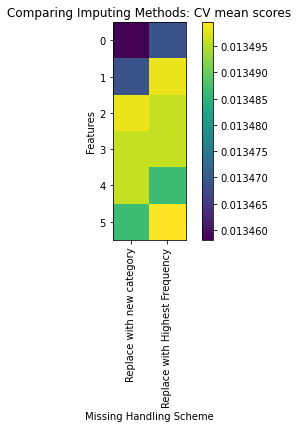

In [12]:
import matplotlib.pyplot as plt
plt.imshow(mean_matrix)
plt.xlabel("Missing Handling Scheme")
plt.ylabel("Features")
_= plt.xticks([0,1], ["Replace with new category", "Replace with Highest Frequency"],rotation='vertical')
plt.colorbar()
plt.title("Comparing Imputing Methods: CV mean scores")

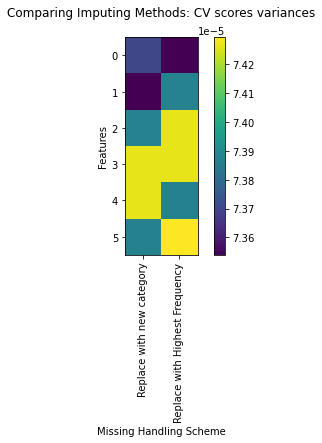

In [15]:
plt.imshow(var_matrix)
plt.xlabel("Missing Handling Scheme")
plt.ylabel("Features")
_= plt.xticks([0,1], ["Replace with new category", "Replace with Highest Frequency"],rotation='vertical')

plt.title("Comparing Imputing Methods: CV scores variances\n")
plt.colorbar()

Each Row in the above matrices correspond a different column/feature and the columns correspond a different imputation scheme. 

The first matrix shows the KFold CV scores(MSE) mean and the second one shows the variation in the CV scores(MSE). 

Looking at these numbers, we come to the conclusion that both of these schemes pretty much have similar effects and we cannot prefer one over the other